[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/lecture9_dnf_restrictions.ipynb)

# Lecture 9: DNFs & Random Restrictions

**Topics**: DNF formulas, Random restrictions, Switching Lemma preview

**O'Donnell Chapters**: 3.3, 4.1, 4.3  
**Based on lecture notes by: Qinggao Hong**  
**Notebook by: Gabriel Taboada**

---

## Key Concepts

| Term | Definition |
|------|------------|
| **DNF** | Disjunctive Normal Form (OR of ANDs) |
| **Width** | Maximum clause size in DNF |
| **Random Restriction** | Fix random subset of variables, leave rest "free" |
| **$p$-random restriction** | Each variable is free with probability $p$ |

**Main result**: Width-$w$ DNFs have total influence $\leq w$ (Theorem 9.3)

In [1]:
# Install/upgrade boofun (required for Colab)
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/Library/Python/3.9/lib/python/site-packages/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/Library/Python/3.9/lib/python/site-packages/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.analysis import SpectralAnalyzer
from boofun.analysis.restrictions import (
    random_restriction,
    apply_restriction,
    restriction_shrinkage,
)

import warnings
warnings.filterwarnings('ignore')

---
## 1. DNFs and Fourier Concentration

**Tribes** is the canonical balanced DNF: $k$ "tribes" of $w$ variables each, where a tribe is satisfied if ALL its members are +1.

$$\text{Tribes}_{k,w}(x) = \bigvee_{i=1}^{k} \bigwedge_{j \in T_i} x_j$$

In [3]:
# Tribes function is a canonical DNF
tribes = bf.tribes(3, 9)  # 3 tribes of 3 variables each
print(f"Tribes(3,9): {tribes.n_vars} variables (3 tribes × 3 vars each)")
print(f"Total Influence: {tribes.total_influence():.4f}")

# Spectral weight by degree
weights = tribes.spectral_weight_by_degree()
print(f"\nFourier weight by degree (W_k = Σ|S|=k f̂(S)²):")
for k, w in weights.items():
    bar = '█' * int(w * 40)
    print(f"  k={k}: {w:.4f} {bar}")

# Spectral concentration
analyzer = SpectralAnalyzer(tribes)
print(f"\nSpectral concentration (cumulative weight):")
for d in range(1, tribes.n_vars + 1):
    conc = analyzer.spectral_concentration(d)
    if conc > 0.99:
        print(f"  W^≤{d}[f] = {conc:.4f}  ← 99% of weight by degree {d}")
        break
    elif d <= 5:
        print(f"  W^≤{d}[f] = {conc:.4f}")

Tribes(3,9): 9 variables (3 tribes × 3 vars each)
Total Influence: 1.7227

Fourier weight by degree (W_k = Σ|S|=k f̂(S)²):
  k=0: 0.1155 ████
  k=1: 0.3297 █████████████
  k=2: 0.3499 █████████████
  k=3: 0.1507 ██████
  k=4: 0.0349 █
  k=5: 0.0151 
  k=6: 0.0035 
  k=7: 0.0005 
  k=8: 0.0001 
  k=9: 0.0000 

Spectral concentration (cumulative weight):
  W^≤1[f] = 0.4452
  W^≤2[f] = 0.7951
  W^≤3[f] = 0.9458
  W^≤4[f] = 0.9807
  W^≤5[f] = 0.9958  ← 99% of weight by degree 5


---
## 2. Random Restrictions

**Definition 9.6**: A restriction $(J, z)$ fixes variables outside $J$ to values $z$, leaving $J$ "free".

**$p$-random restriction**: Each variable is independently free with probability $p$.

The restricted function $f_{J,z}: \{\pm 1\}^J \to \{\pm 1\}$ has fewer variables.

In [4]:
# Demonstrate random restrictions
f = bf.majority(7)
print(f"Original: Majority-7 ({f.n_vars} variables)")
print(f"Total influence: {f.total_influence():.4f}")

rng = np.random.default_rng(42)

# Apply a p=0.5 random restriction
p = 0.5
rho = random_restriction(f.n_vars, p, rng)
print(f"\nRestriction (p={p}): {rho}")
print(f"  Fixed vars: {dict(rho.fixed)}")
print(f"  Free vars: {sorted(rho.free)}")

# Apply the restriction
f_restricted = apply_restriction(f, rho)
print(f"\nRestricted function: {f_restricted.n_vars} free variables")
print(f"Restricted total influence: {f_restricted.total_influence():.4f}")

Original: Majority-7 (7 variables)
Total influence: 2.1875

Restriction (p=0.5): 1*10*11
  Fixed vars: {0: 1, 2: 1, 3: 0, 5: 1, 6: 1}
  Free vars: [1, 4]

Restricted function: 2 free variables
Restricted total influence: 0.0000


---
## 3. The "High-Pass Filter" Effect

**Key intuition**: Random restrictions act like a **high-pass filter** on Fourier weights!

From Proposition 9.7, after a random $p$-restriction:
- Low-degree coefficients "survive" with probability $p^{|S|}$
- High-degree coefficients are more likely to be killed

**Result**: The restricted function has weight shifted toward **higher relative degrees**.

Fourier Weight Distribution Shift (Tribes 3×3)
Original: 9 vars, Restricted: ~4.5 free vars (p=0.5)



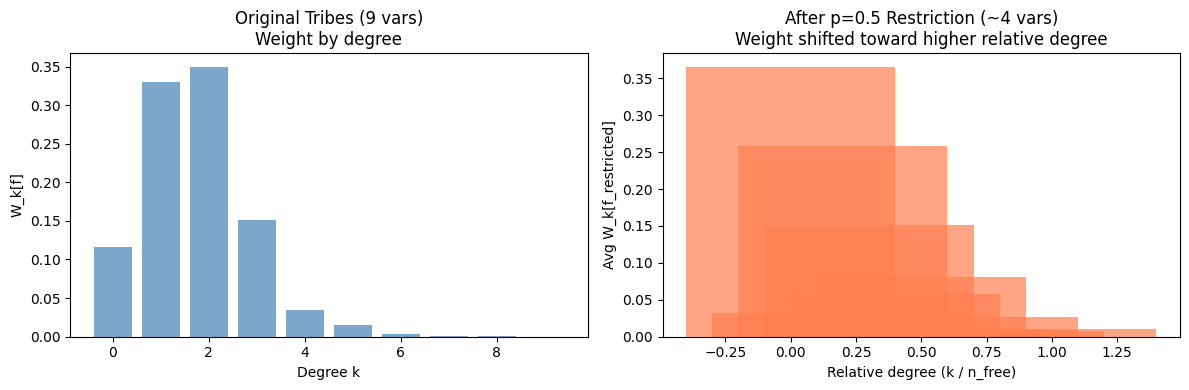


→ Random restrictions 'filter out' low-degree structure!


In [5]:
# Demonstrate the high-pass filter effect
def compare_weight_distribution(f, p=0.5, num_samples=50, seed=42):
    """Compare Fourier weight distribution before/after restriction."""
    rng = np.random.default_rng(seed)
    
    # Original weights (normalized by degree)
    original_weights = f.spectral_weight_by_degree()
    n_orig = f.n_vars
    
    # Collect restricted weights across samples
    restricted_weights_sum = {}
    valid_samples = 0
    avg_free_vars = 0
    
    for _ in range(num_samples):
        rho = random_restriction(f.n_vars, p, rng)
        f_rho = apply_restriction(f, rho)
        
        if f_rho.n_vars > 0:
            avg_free_vars += f_rho.n_vars
            weights = f_rho.spectral_weight_by_degree()
            for k, w in weights.items():
                # Normalize by number of free vars for comparison
                relative_degree = k / f_rho.n_vars if f_rho.n_vars > 0 else 0
                bucket = round(relative_degree, 1)  # Bucket into 0.0, 0.1, ..., 1.0
                restricted_weights_sum[bucket] = restricted_weights_sum.get(bucket, 0) + w
            valid_samples += 1
    
    avg_free_vars /= valid_samples if valid_samples > 0 else 1
    
    # Normalize restricted weights
    for k in restricted_weights_sum:
        restricted_weights_sum[k] /= valid_samples
    
    return original_weights, restricted_weights_sum, avg_free_vars

# Test on Tribes
tribes = bf.tribes(3, 9)
orig, rest, avg_free = compare_weight_distribution(tribes, p=0.5)

print("Fourier Weight Distribution Shift (Tribes 3×3)")
print("="*55)
print(f"Original: {tribes.n_vars} vars, Restricted: ~{avg_free:.1f} free vars (p=0.5)")
print()

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Original
degrees = sorted(orig.keys())
weights = [orig[k] for k in degrees]
ax1.bar(degrees, weights, color='steelblue', alpha=0.7)
ax1.set_xlabel('Degree k')
ax1.set_ylabel('W_k[f]')
ax1.set_title(f'Original Tribes ({tribes.n_vars} vars)\nWeight by degree')

# Restricted (by relative degree)
rel_degrees = sorted(rest.keys())
rel_weights = [rest[k] for k in rel_degrees]
ax2.bar(rel_degrees, rel_weights, color='coral', alpha=0.7)
ax2.set_xlabel('Relative degree (k / n_free)')
ax2.set_ylabel('Avg W_k[f_restricted]')
ax2.set_title(f'After p=0.5 Restriction (~{avg_free:.0f} vars)\nWeight shifted toward higher relative degree')

plt.tight_layout()
plt.show()

print("\n→ Random restrictions 'filter out' low-degree structure!")

---
## 4. Shrinkage Under Restrictions

**Lemma 9.9**: $\mathbb{E}[\text{Inf}[f_{J,z}]] = p \cdot \text{Inf}[f]$

Random restrictions **shrink** complexity measures:
- Total influence scales by $p$
- Decision tree depth decreases dramatically (Switching Lemma)

In [6]:
# Demonstrate shrinkage
print("Shrinkage Under Random Restrictions")
print("="*55)

functions = {
    "Tribes(3,9)": bf.tribes(3, 9),
    "Majority-9": bf.majority(9),
    "Parity-8": bf.parity(8),
}

for name, f in functions.items():
    stats = restriction_shrinkage(f, p=0.5, num_samples=100)
    
    print(f"\n{name}:")
    print(f"  Original DT depth: {stats['original_dt_depth']}")
    print(f"  Avg restricted DT depth: {stats['avg_restricted_dt_depth']:.2f}")
    print(f"  Depth shrinkage: {stats['depth_shrinkage_factor']:.2f}x")
    print(f"  Became constant: {stats['constant_fraction']*100:.0f}% of restrictions")

Shrinkage Under Random Restrictions



Tribes(3,9):


  Original DT depth: 9
  Avg restricted DT depth: 2.48
  Depth shrinkage: 0.28x
  Became constant: 1% of restrictions

Majority-9:
  Original DT depth: 9
  Avg restricted DT depth: 4.26
  Depth shrinkage: 0.47x
  Became constant: 0% of restrictions

Parity-8:
  Original DT depth: 8
  Avg restricted DT depth: 4.17
  Depth shrinkage: 0.52x
  Became constant: 0% of restrictions


---
## Summary

| Result | Statement |
|--------|----------|
| **Thm 9.3** | Width-$w$ DNF has $\text{Inf}[f] \leq w$ |
| **Prop 9.2** | Width-$w$ DNF is $\varepsilon$-concentrated on degree $O(w/\varepsilon)$ |
| **Lemma 9.9** | $\mathbb{E}[\text{Inf}[f_{J,z}]] = p \cdot \text{Inf}[f]$ |

**Switching Lemma** (next lecture): After $p$-restriction, width-$w$ DNF becomes depth-$O(\log(1/p))$ decision tree with high probability.

### boofun API

```python
from boofun.analysis.restrictions import random_restriction, apply_restriction

rho = random_restriction(n, p)      # Generate p-random restriction
f_rho = apply_restriction(f, rho)   # Apply to get restricted function
f.spectral_weight_by_degree()       # W_k[f] for each degree k
restriction_shrinkage(f, p)         # Statistics on shrinkage
```